<br> 
Here I show how python (more specifically pandas and matplotlib) can be used to manipulate data, perform statistical analyses, and output graphs. 
<br><br> 
Specifically I will take the data from the Excel file and sort them into dataframes by Excel sheet; make sure the data types are as intended; merge relevant dataframes; calculate average noodle consumption per capita; and look at the variation in review scores between Asian and non-Asian countries, and among countries with at least 50 reviews in the database.

In [1]:
# The first step is importing the necessary modules along with %matplotlib inline
# so plots appear in the jupyter notebook without calling plt.show() for each plot.

%matplotlib inline 
import numpy as np #for arrays
import pandas as pd #for dataframes
import matplotlib.pyplot as plt #for graphing/visualization
import seaborn as sns #to supplement plt
import scipy.stats as stats #for statistical analysis


# Then, import the excel data using pandas. The excel file is added, and then the different sheets read separately.

xls = pd.ExcelFile('Ramen Full List 2022.06.03.xlsx')
dfrev=pd.read_excel(xls,'Reviewed')
dfran=pd.read_excel(xls,'Ranking')
dfctr=pd.read_excel(xls,'Country Info')
dfcon=pd.read_excel(xls,'Instant Noodle Consumption')
dfurl=pd.read_excel(xls,'URL')

In [2]:
# The next step is cleaning up some of the datatypes in the dataframes (after verifying them with .dtypes, not shown here).

dfran[['Review_ID','Rank_Year','Rank']]= dfran[['Review_ID','Rank_Year','Rank']].astype('int')
dfrev[['Review_ID','Country_ID']] = dfrev[['Review_ID','Country_ID']].astype('int')
(dfctr[['Country_ID','2016_Population', '2017_Population', '2018_Population',
 '2019_Population', '2020_Population', 'Avg_Population']]) = (
     dfctr[['Country_ID','2016_Population', '2017_Population', '2018_Population', 
    '2019_Population', '2020_Population', 'Avg_Population']].astype('int'))
dfurl[['Review_ID']] = dfrev[['Review_ID']].astype('int')

# Then print the types so we can see that everything is as intended.

print('drev\n', dfrev.dtypes, '\n'*2, 'dfran\n', dfran.dtypes, '\n'*2, 'dfctr\n', dfctr.dtypes, 
'\n'*2, 'dfcon\n', dfcon.dtypes, '\n'*2, 'dfurl\n', dfurl.dtypes)

drev
 Review_ID               int64
Review_Date    datetime64[ns]
Brand                  object
Variety                object
Style                  object
Country_ID              int64
Stars                 float64
dtype: object 

 dfran
 Review_ID         int64
Rank_Year         int64
Rank_Category    object
Rank              int64
dtype: object 

 dfctr
 Country_ID          int64
Country            object
Subregion          object
Region             object
2016_Population     int64
2017_Population     int64
2018_Population     int64
2019_Population     int64
2020_Population     int64
Avg_Population      int64
dtype: object 

 dfcon
 Country              object
2016_Consumption    float64
2017_Consumption    float64
2018_Consumption    float64
2019_Consumption    float64
2020_Consumption    float64
Avg_Consumption     float64
dtype: object 

 dfurl
 Review_ID     int64
URL          object
dtype: object


<br>
Next, I merge dataframes of separate sheets into larger dataframes. Namely we will make two large dataframes that we will pick and choose from: "dfrev" with all of the review info, and "dfcountries" with all of the country info.

In [3]:
# I am using an outer join for the dfrev-dfran merge because not all reviewed noodles received awards, but some received more than one.

dfrev = dfrev.merge(dfurl, on='Review_ID')
dfrev = dfrev.merge(dfran, on='Review_ID', how='outer')

# I am using a left join for the dfctr-dfcon merge because the additional countries listed in the dfcon dataframe won't be used in
# this analysis (World and "Other" consumption data. The reviews database does not have reviews from country "World" or country "Other").

dfcountries = dfctr.merge(dfcon, on = 'Country', how = 'left')

In [4]:
# Here I calculate and add the average consumption per capita for each country using the average consumption and
# average population columns, and then round to two decimal places.

dfcountries['Avg_Consumption_Per_Capita'] = dfcountries['Avg_Consumption']/dfcountries['Avg_Population']
dfcountries['Avg_Consumption_Per_Capita'] = dfcountries['Avg_Consumption_Per_Capita'].round(decimals=2)

# Let's take a look at how the consumption per capita looks, sorting the values from highest to lowest.

print(dfcountries[['Country','Avg_Consumption_Per_Capita']].sort_values(by='Avg_Consumption_Per_Capita', ascending=False))


                 Country  Avg_Consumption_Per_Capita
36           South Korea                       75.93
45               Vietnam                       57.87
24                 Nepal                       53.79
40              Thailand                       50.40
16             Indonesia                       47.33
..                   ...                         ...
17               Ireland                        0.19
42  United Arab Emirates                        0.19
18                Israel                        0.19
32              Portugal                        0.19
64                 World                         NaN

[65 rows x 2 columns]


<br>
Now I will make a separate dataframe to only look at average star values per country.


In [5]:
# First, I filter out countries with at least 15 noodles reviewed in the database so outliers don't skew the data.

filtered_dfrev = dfrev.groupby("Country_ID").filter(lambda x: len(x) >= 15)

# Then I isolate the two relevant columns: Country_ID (Which we will use to merge the country data from the countries database) and Stars.

dfmeanstars = filtered_dfrev[['Country_ID','Stars']]
dfmeanstars = dfmeanstars.groupby('Country_ID').mean()

# Finally, I take the mean star score of this new database "dfmeanstars" grouping by country ID, and round the value to 2 decimal places.

dfmeanstars['Stars'] = dfmeanstars['Stars'].round(decimals=2)

In [6]:
# Here I merge the relevant columns from the dfcountries dataframe to dfmeanstars and reorder the columns

dfmeanstars = dfmeanstars.merge(dfcountries[['Country_ID','Country','Avg_Consumption_Per_Capita']], on='Country_ID')
dfmeanstars = dfmeanstars[['Country_ID', 'Country', 'Avg_Consumption_Per_Capita', 'Stars']]

#For fun, I'll add a percentile rank to the star rating

dfmeanstars['Percentile_Star_Rank'] = dfmeanstars['Stars'].rank(pct = True).round(decimals=2)

# Let's take a look at it (removing the country_id column since it's irrelevant), sorting the data by star rating in descending order.

dfmeanstars.loc[:, dfmeanstars.columns != 'Country_ID'].sort_values(by='Stars', ascending=False)

,Country,Avg_Consumption_Per_Capita,Stars,Percentile_Star_Rank
9,Malaysia,44.98,4.36,1.00
14,Singapore,22.94,4.29,0.95
7,Indonesia,47.33,4.19,0.90
16,Taiwan,34.74,4.05,0.86
11,Myanmar,11.32,4.02,0.81
15,South Korea,75.93,3.99,0.76
5,Hong Kong,28.66,3.97,0.71
8,Japan,45.14,3.85,0.67
10,Mexico,8.40,3.73,0.62
1,Brazil,11.63,3.65,0.57


<br>
Now let's see what the correlation is between the consumption per capita and the star rating.
Here I use seaborn to graph a linear regression, then scipy.stats to compute the statistics (r, r-squared, and the p-value).
<br><br>
Since scipy.stats doesn't provide r-squared, I calculate it separately and print it, along with r and the p-value.

Pearson's r: 0.455610 r-squared: 0.207580 P-value: 0.037931


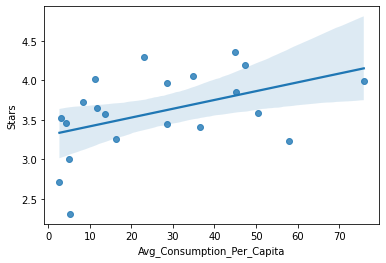

In [7]:
sns.regplot(x='Avg_Consumption_Per_Capita', y='Stars', data=dfmeanstars)
regstats=stats.linregress(x=dfmeanstars['Avg_Consumption_Per_Capita'], y=dfmeanstars['Stars'])

print(f"Pearson's r: {regstats.rvalue:.6f} r-squared: {regstats.rvalue**2:.6f} P-value: {regstats.pvalue:.6f}")

<br>
The p-value tells us the correlation between average noodle consumption per capita and that nation's average noodle star rating is statistically significant, but Pearson's r tells us it is relatively weak. That is to say, nations that consume more noodles do tend to produce better ones, but consumption per capita isn't the greatest predictor for review score.
<br><br>
The r-squared value tells us that roughly 21% of the variation in the star ranking is explained by consumption per capita (i.e., variation in consumption per capita contributes to 21% of the variation in star rating).

In [8]:
# Let's now look at boxplots of star ratings in Asian countries vs. the rest of the world. To do this,
# I'll first merge the Region column from dfcountries onto the filtered_dfrev dataframe from before.

regboxdf = filtered_dfrev.merge(dfcountries[['Country_ID','Region']], on='Country_ID', how= 'left')

# Next, I will replace all of the non-Asian countries with Region as "Rest of World"

regboxdf.loc[regboxdf['Region']!='Asia','Region'] = 'Rest of World'


In [9]:
#Some of the Star ratings are "NaN" though, so we shall drop those first (I have checked the original 
# database and confirmed these items never received a star rating, so it makes sense for that data to be 'missing').

regboxdf.dropna(subset=['Stars'], inplace=True)

                Stars                                              
                count      mean       std  min  25%  50%   75%  max
Region                                                             
Asia           3616.0  3.902046  1.072434  0.0  3.5  4.0  5.00  5.0
Rest of World   929.0  3.416728  1.288283  0.0  3.0  3.5  4.25  5.0


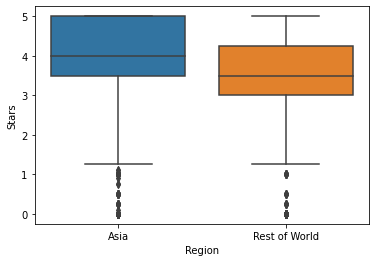

In [10]:
#Now let's do a boxplot and get some summary statistics.

sns.boxplot(x='Region', y='Stars', data=regboxdf, order=['Asia','Rest of World'])
print(regboxdf[['Region', 'Stars']].groupby('Region').describe())


<br>
On average, Asian noodles rate roughtly half a star higher than noodles from the rest of the world. The standard deviation is lower as well, meaning there is less spread in rating variation. Looking at the quartiles, the upper quartile for non-Asian noodles is 4.25 stars, meaning 75% of the reviews received a score of 4.25 or worse. For asian noodles, on the other hand, we know at least 25% of all reviews were the full 5-star rating, as the upper quartile is already at 5.00. 
<br><br>
Next we will run a T-test to verify that the difference between the two groups is statistically significant. But T-tests are usually reserved for normally distributed data, so we need to check if that is the case for our data sample. Let's put them in histograms and see.

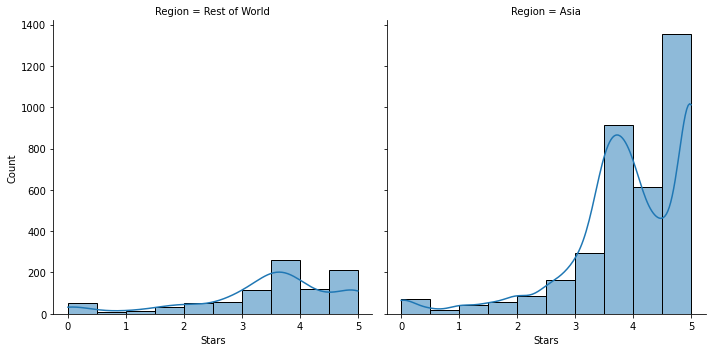

In [11]:
sns.displot(data=regboxdf, x="Stars", col="Region", bins=10, kde=True)

<br>
Even though the data distribution is non-parametric (looks more ordinal than normal), the sample size should be large enough to safely use a T-test.
<br><br>
Still, let's do a Mann-Whitney U test instead (a T-test equivalent that doesn't assume normality) just to be safe, and see if the difference between the two groups is statistically significant. I am keeping the T-test command commented out for reference.

In [12]:
asiastars = regboxdf[regboxdf['Region']=='Asia']['Stars']
reststars = regboxdf[regboxdf['Region']=='Rest of World']['Stars']

# stats.ttest_ind(asiastars, reststars)

mannwhitney = stats.mannwhitneyu(asiastars, reststars)
print("p-value:", mannwhitney[1])


p-value: 9.175042388543265e-30


<br>
The p-value is much lower than the usual 0.05 threshold (meaning a 5% chance the data was distributed this way by random chance), so we can safely stay the variation in noodle star rating between Asian and non-Asian noodles is statistically significant.
<br><br>
Next, let's take a more granular look at the countries, filtering to those with at least 50 reviews. Let's first see a boxplot of their rating scores.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'Thailand'),
  Text(2, 0, 'Vietnam'),
  Text(3, 0, 'Taiwan'),
  Text(4, 0, 'South Korea'),
  Text(5, 0, 'Japan'),
  Text(6, 0, 'Philippines'),
  Text(7, 0, 'Singapore'),
  Text(8, 0, 'Indonesia'),
  Text(9, 0, 'China'),
  Text(10, 0, 'Hong Kong'),
  Text(11, 0, 'Malaysia'),
  Text(12, 0, 'Canada'),
  Text(13, 0, 'United Kingdom')])

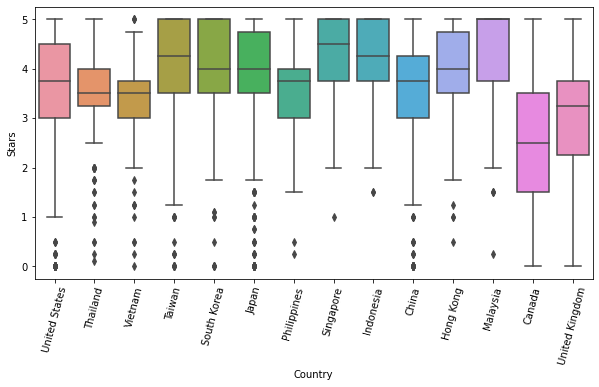

In [13]:
# First filtering the dfrev dataframe to 50 reviews and merging the relevant columns from the dfcountries dataframe.

fiftyfilter_dfrev = dfrev.groupby("Country_ID").filter(lambda x: len(x) >= 50) 
anovaregbox = fiftyfilter_dfrev.merge(dfcountries[['Country_ID','Country']], on='Country_ID', how= 'left')

# Next, plotting the boxplot

plt.figure(figsize = (10,5))
sns.boxplot(x='Country', y='Stars', data=anovaregbox)
plt.xticks(rotation=75)

<br>
The review scores look quite varied, but is the difference statistically significant? To verify this, we must run an ANOVA test. But we can't just run an ANOVA test with the 'Country' and 'Stars' columns because the command compares values from column to column. One may be tempted to pivot the anovaregbox dataframe to make the 'Country' values into columns, but this would not work. I will show why after running the statistic tests.
<br><br>
Instead, I will make a "list of lists" using a for loop, with each list including the star values of each country. I will then compare those lists  to each other. Note that some of the star values are NaN, and those need to be dropped.

In [14]:
values = []
for country in anovaregbox['Country'].unique():
    _anovaregbox = anovaregbox[anovaregbox['Country']==country]
    values.append(_anovaregbox['Stars'].dropna())

In [15]:
# Here I perform a one-way ANOVA with the lists in values.

anova = stats.f_oneway(*values)
print("F statistic:", anova[0], "p-value:", anova[1])

F statistic: 35.462409222614184 p-value: 1.518245990663163e-85


<br>
The p-value is again lower than the 0.05 threshold so the difference is statistically significant. However, like the T-test from earlier, the ANOVA test usually requires that the data be parametric, which this star rating data is not. The results should still be okay thanks to the large sample size, but just to be safe we can run a Kruskal–Wallis test instead (the ANOVA equivalent for non-normal data) and verify.

In [16]:
kruskal = stats.kruskal(*values)
print("p-value:",kruskal[1])

p-value: 1.4662975044672596e-88


<br>
Still statistically significant!
<br><br>
Now, why would the pivot method not work on the anovaregbox dataframe for testing? Because the different countries don't have the same number of reviews, and pivoting the table would fill it with NaN values. We could theoretically fill all the NaN with 0, but that would skew the test results. I will demonstrate this below.

In [17]:
# Selecting the columns from anovaregbox to pivot (named "wronganova"), pivoting it, and filling the nAn values with 0

anovamelt = anovaregbox[['Country','Stars']]
wronganova = anovamelt.pivot(columns='Country', values='Stars').fillna(0)
print(wronganova)

Country  Canada  China  Hong Kong  Indonesia  Japan  Malaysia  Philippines  \
0           0.0    0.0        0.0        0.0    0.0       0.0          0.0   
1           0.0    0.0        0.0        0.0    0.0       0.0          0.0   
2           0.0    0.0        0.0        0.0    0.0       0.0          0.0   
3           0.0    0.0        0.0        0.0    0.0       0.0          0.0   
4           0.0    0.0        0.0        0.0    0.0       0.0          0.0   
...         ...    ...        ...        ...    ...       ...          ...   
4344        0.0    1.5        0.0        0.0    0.0       0.0          0.0   
4345        0.0    5.0        0.0        0.0    0.0       0.0          0.0   
4346        0.0    2.5        0.0        0.0    0.0       0.0          0.0   
4347        0.0    0.0        0.0        0.0    0.0       0.0          0.0   
4348        0.0    0.0        0.0        0.0    3.0       0.0          0.0   

Country  Singapore  South Korea  Taiwan  Thailand  United Kingd

In [18]:
# Now running the ANOVA test. We use the * syntax to iterate through the different columns
#  (otherwise we would have to write out all of the country names)

wronganovastat = stats.f_oneway(*(wronganova[col] for col in wronganova.columns))

print("Accurate F statistic:", anova[0])
print("Wrong F statistic:", wronganovastat[0],"\n")
print("Accurate p-value:", anova[1])
print("Wrong p-value:", wronganovastat[1])

Accurate F statistic: 35.462409222614184
Wrong F statistic: 198.8185240551246 

Accurate p-value: 1.518245990663163e-85
Wrong p-value: 0.0


<br>
The difference is pretty significant! It greatly inflated the F statistic, and in turn makes the p-value virtually 0.
This is why, when it comes to statistical analysis, in most cases NaN should be treated as NaN and not 0!
<br><br>
This concludes the sample analysis using python.